# forecasting daily sales using autoregressive model (ARIMA)

### import statements (data maniupulation packages, stats packages, viz packages)

In [30]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [31]:
from statsmodels.graphics.api import qqplot

In [32]:
from pandas.tools.plotting import autocorrelation_plot

### reading data, creating timeseries, and plotting daily sales

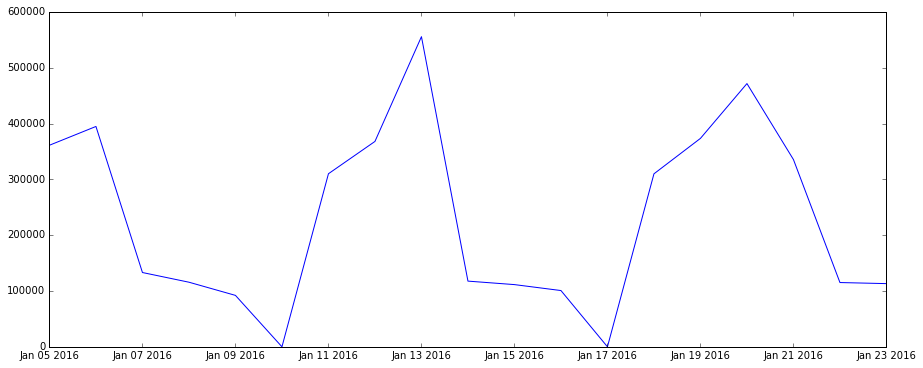

In [33]:
data = pd.read_csv('../../../sample.csv')

data['timestamp'] = pd.to_datetime(data['name-node_ide_dhEmi_$date'])

data = data.set_index('timestamp')

def _sum(x):
    if len(x) == 0: return 0
    else: return sum(x)

dataset = data['name-node_total_icmsTot_vProd'].groupby(pd.TimeGrouper('D'))\
                                                .transform(np.cumsum)\
                                                .resample('D').apply(_sum)
plt.plot(dataset)
plt.show()

### investigating series "by hour"

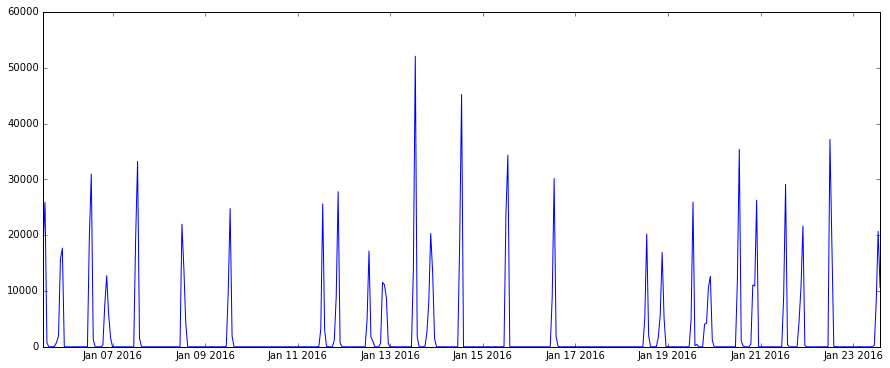

In [34]:
by_hr = data['name-node_total_icmsTot_vProd'].groupby(pd.TimeGrouper('H')).transform(np.cumsum).resample('H').apply(_sum)
plt.plot(by_hr)
plt.show()

#### filtering hours during which no sales occur

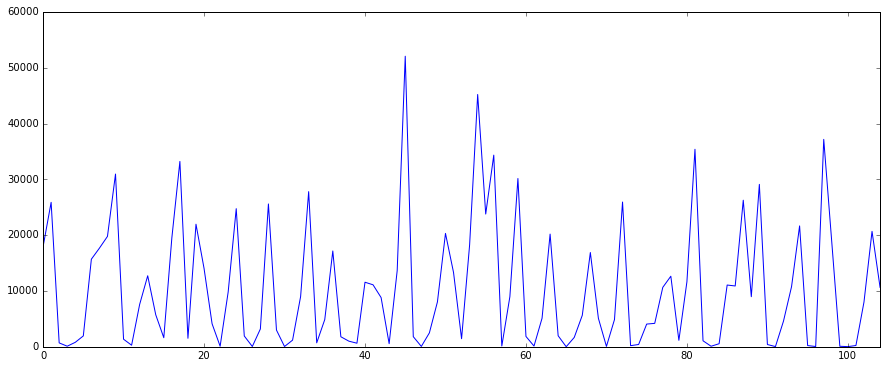

In [35]:
pd.Series(by_hr[by_hr!=0].tolist()).plot()

## at this point, switching back to "by days," as it is a more meaningful, though smaller dataset

##### db test indicates there may be some autocorrelation in the data, will investigate modeling efforts appropriately

In [36]:
sm.stats.durbin_watson(dataset)

0.39533599082236254

###### further investigating autocorrelation

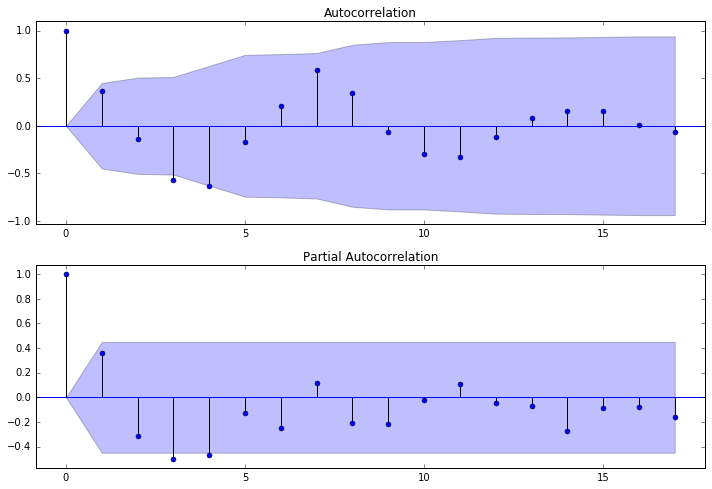

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset.values.squeeze(), lags=17, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset, lags=17, ax=ax2)

In [10]:
dataset = dataset.to_frame()

In [11]:
dataset.head(3)

,name-node_total_icmsTot_vProd
timestamp,
2016-01-05,361228.32
2016-01-06,394866.27
2016-01-07,133111.49


### renaming

In [12]:
dataset['sales'] = dataset['name-node_total_icmsTot_vProd'].rename('sales')
dataset = dataset.drop('name-node_total_icmsTot_vProd', axis=1)

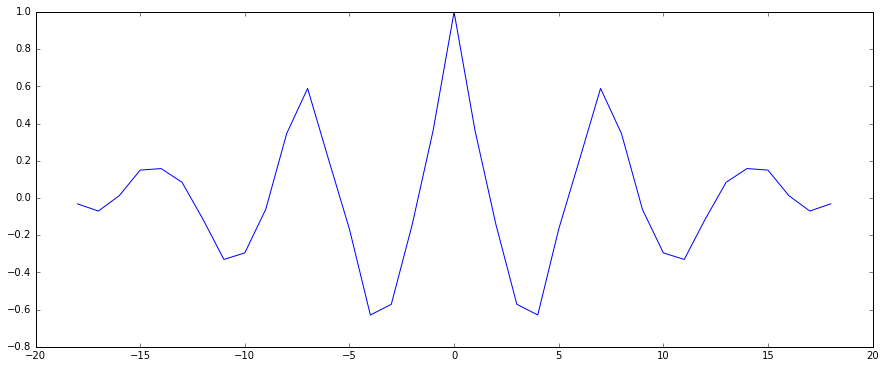

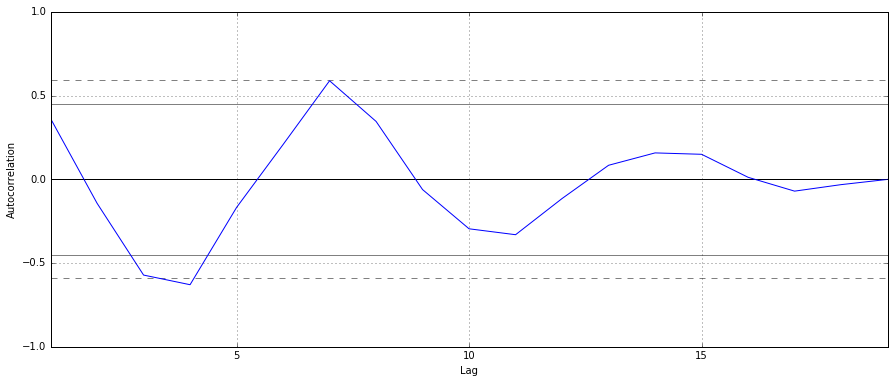

In [13]:
dataset['sales_2'] = dataset['sales']
dataset['sales_2'] = (dataset['sales_2'] - dataset['sales_2'].mean()) / (dataset['sales_2'].std())
plt.acorr(dataset['sales_2'],maxlags = len(dataset['sales_2']) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(dataset['sales'])
plt.show()

In [14]:
dataset = dataset.drop('sales_2', axis=1)

In [15]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [16]:
def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat))

### trying with 1 autoregressive term and 1 moving average term

In [17]:
arima_mod1 = sm.tsa.ARIMA(dataset.sales, (1,0,1)).fit()

In [18]:
print arima_mod1.params

const          230540.268038
ar.L1.sales         0.165646
ma.L1.sales         0.258249
dtype: float64


##### db test is close to 2, indicating no autocorrelation

In [19]:
sm.stats.durbin_watson(arima_mod1.resid.values)

1.8864830968867112

#### values to minimize

In [20]:
print arima_mod1.aic, arima_mod1.bic, arima_mod1.hqic

514.153424781 517.931180698 514.792771177


### evaluating residuals

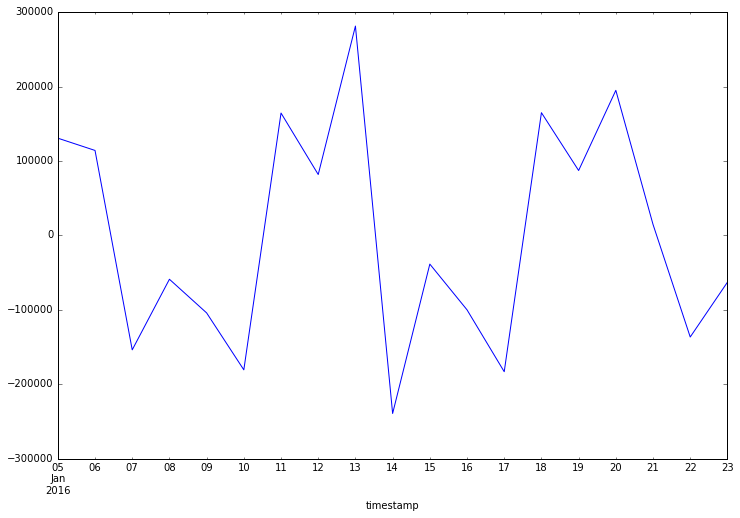

In [21]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arima_mod1.resid.plot(ax=ax) 

In [22]:
resid1 = arima_mod1.resid

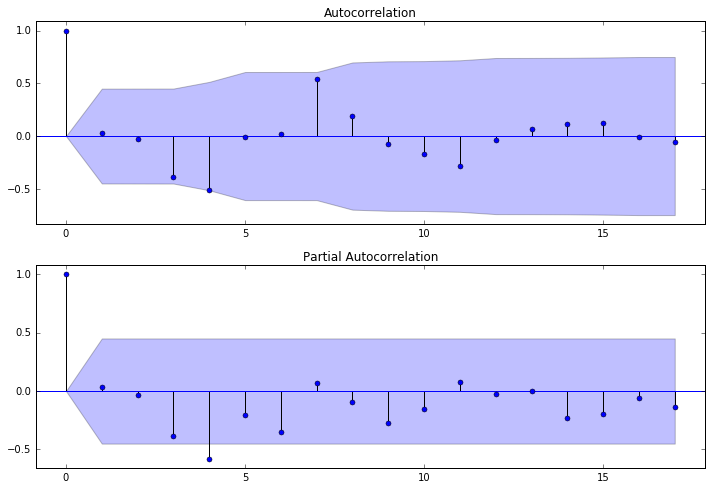

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid1.values.squeeze(), lags=17, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid1, lags=17, ax=ax2)

In [27]:
predictions_1 = arima_mod1.predict('2016-01-09', '2016-03-05', dynamic=True)
print predictions_1

2016-01-09    196305.309919
2016-01-10    224869.389373
2016-01-11    229600.910533
2016-01-12    230384.667367
2016-01-13    230514.493433
2016-01-14    230535.998581
2016-01-15    230539.560820
2016-01-16    230540.150890
2016-01-17    230540.248633
2016-01-18    230540.264823
2016-01-19    230540.267505
2016-01-20    230540.267950
2016-01-21    230540.268023
2016-01-22    230540.268035
2016-01-23    230540.268037
2016-01-24    230540.268038
2016-01-25    230540.268038
2016-01-26    230540.268038
2016-01-27    230540.268038
2016-01-28    230540.268038
2016-01-29    230540.268038
2016-01-30    230540.268038
2016-01-31    230540.268038
2016-02-01    230540.268038
2016-02-02    230540.268038
2016-02-03    230540.268038
2016-02-04    230540.268038
2016-02-05    230540.268038
2016-02-06    230540.268038
2016-02-07    230540.268038
2016-02-08    230540.268038
2016-02-09    230540.268038
2016-02-10    230540.268038
2016-02-11    230540.268038
2016-02-12    230540.268038
2016-02-13    230540

//anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


#### plot signifies severe underfitting

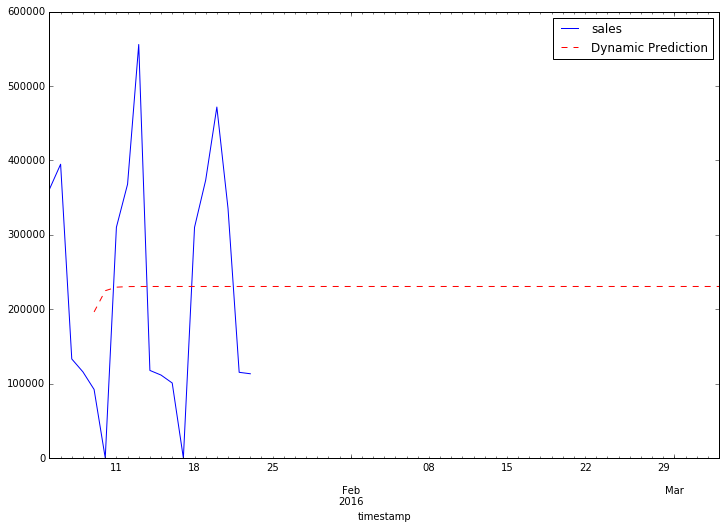

In [28]:
ax = dataset.ix['2016':].plot(figsize=(12,8))
ax = predictions_1.plot(ax=ax, style='r--', label='Dynamic Prediction') 
ax.legend() 

#### 3 autoregressive terms and 2 moving average terms with no correction for seasonality (time period is too short for seasonality)

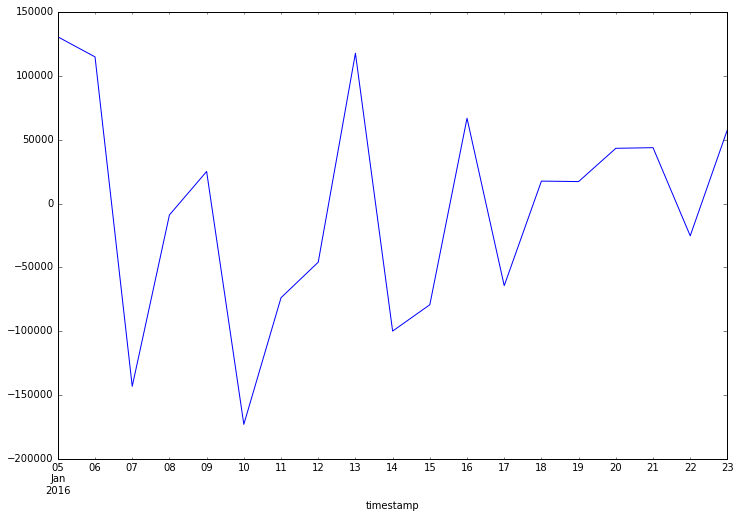

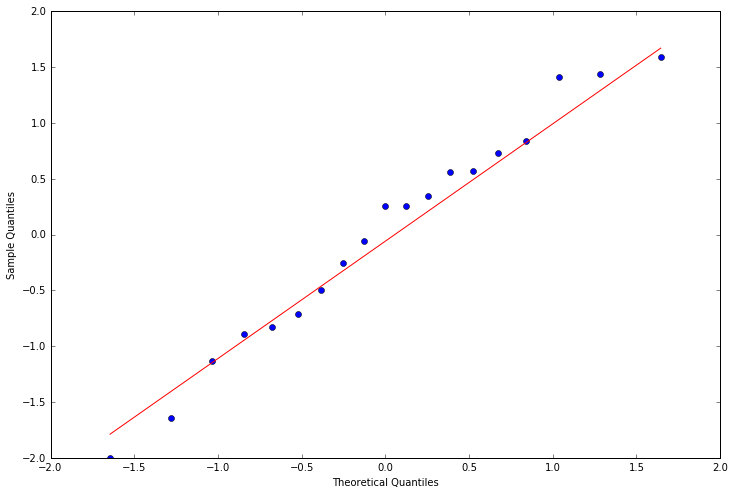

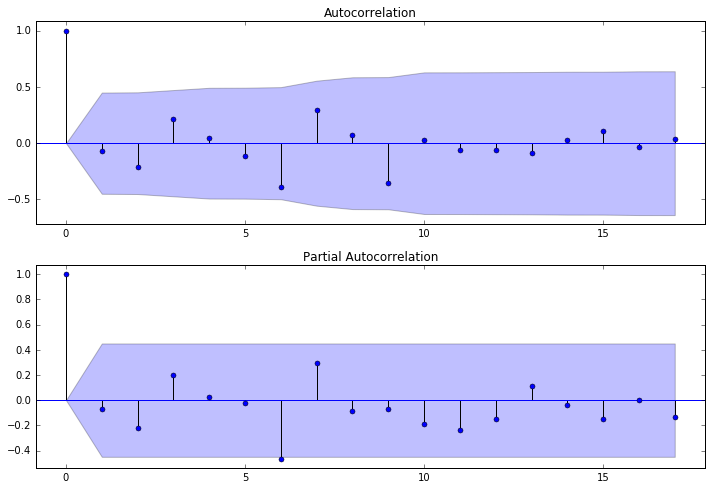

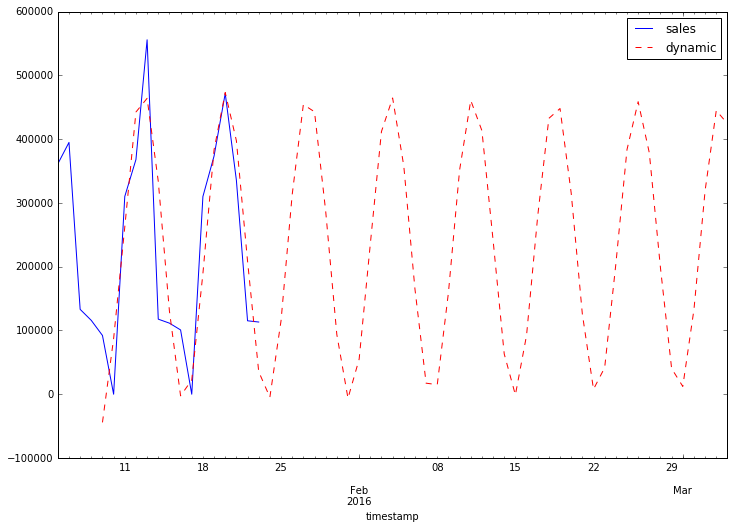

In [29]:
arima_mod1 = sm.tsa.ARIMA(dataset.sales, (3,0,2)).fit()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arima_mod1.resid.plot(ax=ax) 

resid1 = arima_mod1.resid

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid1, line='q', ax=ax, fit=True)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid1.values.squeeze(), lags=17, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid1, lags=17, ax=ax2)

predictions_1 = arima_mod1.predict('2016-01-09', '2016-03-05', dynamic=True)

ax = dataset.ix['2016':].plot(figsize=(12,8))
ax = predictions_1.plot(ax=ax, style='r--', label='dynamic') 
ax.legend(loc='best') 